In [1]:
%load_ext autoreload
%autoreload 2  

In [5]:
from models.WaveRep.detector import WaveRepDetector
from models.R50_nodown.detector import R50NoDownDetector
from support.detect_utils import load_np_image
from detect import parse_weights_map
import os
import importlib.util
from types import ModuleType

from tqdm import tqdm
import torch

mapping = {
    'CLIP-D': ('CLIPDDetector', os.path.join('models', 'CLIP-D', 'detector.py')),
    'NPR': ('NPRDetector', os.path.join('models', 'NPR', 'detector.py')),
    'R50_nodown': ('R50NoDownDetector', os.path.join('models', 'R50_nodown', 'detector.py')),
    'P2G': ('P2GDetector', os.path.join('models', 'P2G', 'detector.py')),
    'R50_TF': ('R50TFDetector', os.path.join('models', 'R50_TF', 'detector.py')),
    'WaveRep': ('WaveRepDetector', os.path.join('models', 'WaveRep', 'detector.py')),
}
def _load_module_from_path(module_name: str, file_path: str) -> ModuleType:
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None or spec.loader is None:
        raise ImportError(f"Cannot load module {module_name} from {file_path}")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)  # type: ignore
    return module


/Users/francescobassignana/miniforge3/envs/trends_cv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from typing import Dict, List

from support.base_detector import BaseDetector

device = torch.device("mps")
def list_images(folder: str) -> List[str]:
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    files = []
    for root, _, fnames in os.walk(folder):
        for f in fnames:
            if os.path.splitext(f)[1].lower() in exts:
                files.append(os.path.join(root, f))
    files.sort()
    return files

def _detector_class_by_name(name: str):
    if name not in mapping:
        raise KeyError(name)
    class_name, path = mapping[name]
    module = _load_module_from_path(f"detector_{name}", path)
    if not hasattr(module, class_name):
        raise AttributeError(f"Class {class_name} not found in {path}")
    return getattr(module, class_name)

def available_detectors(device: torch.device) -> Dict[str, BaseDetector]:
    names = list(mapping.keys())
    instances: Dict[str, BaseDetector] = {}
    for n in names:
        try:
            cls = _detector_class_by_name(n)
            instances[n] = cls(device)
        except Exception as e:
            print(f"[warn] Could not register detector {n}: {e}")
    return instances

In [49]:
limit_per_folder = 10
batch_size = 4
models = ["R50_nodown"]
available_d = available_detectors(device)
selected = list(available_d.keys()) if 'all' in models else models
selected, available_d


[warn] Could not register detector CLIP-D: attempted relative import with no known parent package
[warn] Could not register detector P2G: [Errno 2] No such file or directory: '/Users/francescobassignana/Desktop/school/unitn/adversarial_sensitivity_project/detectors/models/P2G/src/models/clip/bpe_simple_vocab_16e6.txt.gz'


(['R50_nodown'],
 {'NPR': <detector_NPR.NPRDetector at 0x309851ea0>,
  'R50_nodown': <detector_R50_nodown.R50NoDownDetector at 0x309df8280>,
  'R50_TF': <detector_R50_TF.R50TFDetector at 0x309dfba00>,
  'WaveRep': <detector_WaveRep.WaveRepDetector at 0x309dfa110>})

In [54]:
w_map = parse_weights_map(["CLIP-D:./models/CLIP-D/weights/best.pt", "WaveRep:./models/WaveRep/weights/best.ckpt", "R50_nodown:./models/R50_nodown/weights/best.pt"])
# detectors = [(WaveRepDetector(device=device), w_map.get("WaveRep"))]
detectors = []
for name in selected:
    if name not in available_d:
        print(f"[warn] Unknown detector '{name}', skipping")
        continue
    det = available_d[name]
    model_id = w_map.get(name)
    # Do not load here; BaseDetector.run_batch will call load for each detector
    detectors.append((det, model_id))

detectors

[(<detector_R50_nodown.R50NoDownDetector at 0x309df8280>,
  './models/R50_nodown/weights/best.pt')]

In [55]:
for det, model_id in detectors:
    det.load(model_id)

In [57]:
det.model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv

In [58]:
from pytorch_grad_cam import  GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt


det = detectors[0][0]
model = det.model

model.eval()

# For Vision Transformers, target the final block's norm layer or use GradCAM on the last block
# This gives better spatial information than just the attention projection

# Try to use the last block's MLP or output
target_layer = model.layer4[-1].conv3




cam = GradCAM(model=model, target_layers=[target_layer])

R50_nodown on samecat:   0%|          | 0/10 [00:00<?, ?it/s]

shape torch.Size([1, 3, 512, 512])
Model output shape: torch.Size([1, 1])
Model output shape: torch.Size([1, 1])


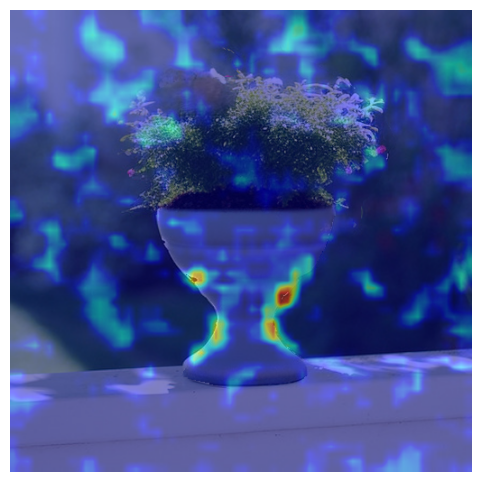

R50_nodown on samecat:  10%|█         | 1/10 [00:42<06:20, 42.33s/it]

shape torch.Size([1, 3, 512, 512])
Model output shape: torch.Size([1, 1])
Model output shape: torch.Size([1, 1])


In [ ]:

for folder in ["../b-free/samecat"]:
    images = list_images(folder)
    if limit_per_folder > 0:
        images = images[:limit_per_folder]


 
    # Fallback to single-image predictions
    for img_path in tqdm(images, desc=f"{det.name} on {os.path.basename(folder)}"):
        img_tensor_cpu, rgb_img = load_np_image(img_path, size=512)

        img_tensor = img_tensor_cpu.to(det.device)
        print(f"shape {img_tensor.shape}")

        # Ensure batch dimension for model forward pass
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.unsqueeze(0)
        
        # Check model output shape (without gradients)
        with torch.no_grad():
            test_output = det.model(img_tensor)
        print(f"Model output shape: {test_output.shape}")
        
        # Use index 0 if output is 1D (single value), else use index 1 (class 1)
        target_idx = 0 if test_output.ndim == 1 or test_output.shape[-1] == 1 else 1
        
        # Convert PIL Image to numpy array and normalize to [0, 1] float32
        rgb_img_np = np.array(rgb_img, dtype=np.float32)
        rgb_img_normalized = rgb_img_np / 255.0 if rgb_img_np.max() > 1 else rgb_img_np
        
        # Now run CAM (gradients will be tracked inside cam())
        grayscle_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_idx)])
        cam_map = grayscle_cam[0, :]
        visualization = show_cam_on_image(rgb_img_normalized, cam_map, use_rgb=True)
        plt.figure(figsize=(6,6))
        plt.imshow(visualization)
        plt.axis("off")
        plt.show()
        # conf = float(det.predict(img_tensor, img_path))
        # print(conf)
        # pred_flag = det.label_from_conf(conf)
            # writer.writerow([
            #     folder,
            #     os.path.relpath(img_path, folder),
            #     det.name,
            #     f"{conf:.6f}",
            #     str(pred_flag),
            # ])
            # f.flush()


In [ ]:
for i, (image, mask, original) in enumerate(dataloader):
    print(f"BATCH {i}: image.shape={image.shape}, mask.shape={mask.shape}")
    explain_map, logits = get_explainability_map(image, detector, is_resnet=is_resnet, device=device)
    vis = visualize_vulnerability_map(explain_map, image)
    plot_triple_res(original, vis, mask)


In [22]:
# Create dataloader AFTER loading the model so we can infer image size
from utils.dataset import BatchedImageIterable
from torch.utils.data import DataLoader
images_dir: str = "./data/COCO_real"
masks_dir: str = "./data/masks"
dataset = BatchedImageIterable(
    images_dir,
    batch_size=1,
)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1)  # dataset yields pre-batched items

In [17]:
import torch.nn.functional as F
import torch
from utils.utils import Metric
avg_estimate = Metric()
for i, (image, mask, orig) in enumerate(dataloader):
    with torch.no_grad():
        logits = detector(image.to(device))
        prob_ai = torch.sigmoid(logits[:, 1])
        for p in prob_ai:
            print(p)
        avg_estimate.update(prob_ai.mean().item(), n=prob_ai.numel())
        # res = detector(image.squeeze(0).to(device))[0][1]
        # print(res)
        # print("after sigmoid:")
        # print(F.sigmoid(res))
        # prob_AI_gen = F.sigmoid(res)
        # avg_estimate.update(prob_AI_gen.mean().item(), n=image.size(0))

print("Average estimated probability of AI-generated content:", avg_estimate.avg())



tensor(0.9729)
tensor(0.9812)
tensor(0.0741)
tensor(0.9804)
tensor(0.9473)
tensor(0.5510)
tensor(0.9593)
tensor(0.8772)
tensor(0.9951)
tensor(0.8999)
tensor(0.9843)
tensor(0.9981)
tensor(0.9480)
tensor(0.7102)
tensor(0.6353)
tensor(0.9992)
tensor(0.9924)
tensor(0.9972)
tensor(0.9794)
tensor(0.2528)
Average estimated probability of AI-generated content: 0.8367652732878923
